# Representing image using watershed segmentation and local Gaussian fit

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import h5py
import dpmeans
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.feature import peak_local_max
from skimage.util import img_as_float, img_as_uint
from skimage.measure import label
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed, random_walker
from scipy import ndimage
from scipy.stats import multivariate_normal

from otimage import readers

### Parameters

In [3]:
# Minimum number of pixels for component to be considered
CELL_MIN_SIZE = 50

### Load Zimmer data

In [4]:
# Path to file containing Zimmer data
in_fpath = '/home/mn2822/Desktop/WormOT/data/zimmer/mCherry_v00065-01581.hdf5'

# Index of frame to use
t_frame = 500

with readers.ZimmerReader(in_fpath) as reader:
    frame = reader.get_frame(t_frame)

### Select section of frame for test image

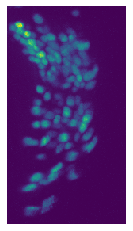

In [5]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Compute image min and max
img_min = np.min(img)
img_max = np.max(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

### Apply threshold to image

In [6]:
# Compute threshold with Otsu's method
threshold_abs = threshold_otsu(img)
idx_below_th = img < threshold_abs
img_th = np.copy(img)
img_th[idx_below_th] = 0.0

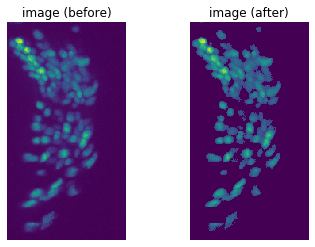

In [7]:
fig = plt.figure()

plt.subplot(121)
plt.imshow(np.max(img, 2).T);
plt.title('image (before)')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.max(img_th, 2).T);
plt.title('image (after)')
plt.axis('off');

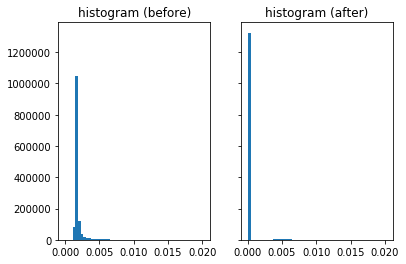

In [8]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].hist(img.flatten(), 50)
axs[0].set_title('histogram (before)')

axs[1].hist(img_th.flatten(), 50);
axs[1].set_title('histogram (after)');

### Find local peaks

In [9]:
peaks = peak_local_max(img_th, min_distance=2)
n_peaks = peaks.shape[0]

#### Plot slices of original image with identified local peaks

In [10]:
def plot_slice_cells(img, cells, z_min, width, ax, vmin=None, vmax=None):
    
    if vmin is None:
        vmin = np.min(img)
    if vmax is None:
        vmax = np.max(img)
    
    z_max = min(z_min + width, img.shape[2])

    img_sl = img[:, :, z_min:z_max]
    cells_sl_idx = (cells[:, 2] >= z_min) & (cells[:, 2] < z_max)
    cells_sl = cells[cells_sl_idx]
    
    ax.imshow(np.max(img_sl, 2).T, vmin=vmin, vmax=vmax);
    ax.scatter(cells_sl[:, 0], cells_sl[:, 1], marker='*', color='r')
    ax.axis('off');
    ax.set_title(f'z: {z_min}-{z_max}')

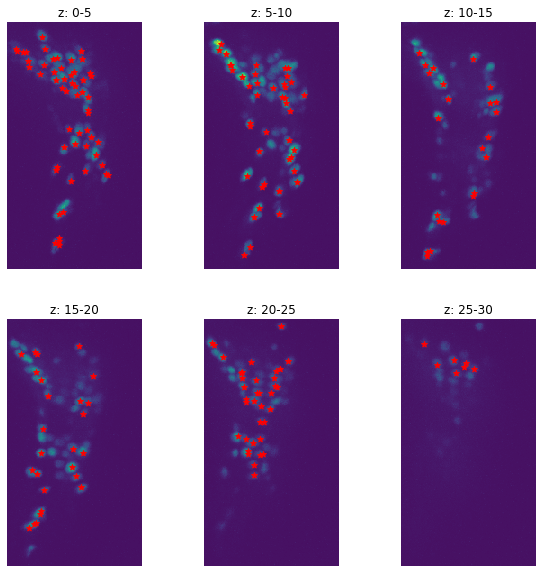

In [11]:
fig, axs = plt.subplots(
    2, 3, 
    sharex=True, sharey=True, 
    figsize=(10, 10)
)

for s in range(0, 6):
    z_min = 5 * s
    width = 5
    ax = axs.flatten()[s]
    plot_slice_cells(img, peaks, z_min, width, ax, vmin=img_min, vmax=img_max)

#### Widget

In [12]:
z_min_widget = widgets.IntSlider(min=0, max=img.shape[2] - 1, step=1, value=0)
width_widget = widgets.IntSlider(min=1, max=img.shape[2], step=1, value=1)

@widgets.interact(z_min=z_min_widget, width=width_widget)
def slice_peak_widget(z_min, width):
    
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plot_slice_cells(img, peaks, z_min, width, ax, vmin=img_min, vmax=img_max)

interactive(children=(IntSlider(value=0, description='z_min', max=32), IntSlider(value=1, description='width',…

### Run segmentation on entire image

In [13]:
# Pixels are marked 'unlabeled' by default
markers = np.zeros_like(img, dtype=np.int)
    
# All pixels below threshold are removed from graph
markers[idx_below_th] = -1

# Each peak is marked with its own positive integer label
mark_vals = np.arange(n_peaks) + 1
markers[peaks[:, 0], peaks[:, 1], peaks[:, 2]] = mark_vals

# Run random walker segmentation algorithm on image, using peaks as starting points
img_seg = random_walker(img, markers)


In [14]:
cell_indices = []
for c in range(n_peaks):
    c_label = mark_vals[c]
    if np.count_nonzero(np.equal(img_seg, c_label)) >= CELL_MIN_SIZE:
        cell_indices.append(c)
        
n_cells = len(cell_indices)

#### Viewing widget

In [15]:
@widgets.interact(
    cell=widgets.IntSlider(min=0, max=n_cells - 1, step=1, value=0)
)
def cell_label_widget(cell):
    
    c_idx = cell_indices[cell]
    
    c_label = mark_vals[c_idx]
    c_img = np.equal(img_seg, c_label).astype(np.int)
    c_peak = peaks[c_idx, :]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.max(img, 2).T, cmap='gray')
    plt.imshow(np.max(c_img, 2).T, alpha=0.5)
    plt.scatter(c_peak[0], c_peak[1], marker='*', color='red');

interactive(children=(IntSlider(value=0, description='cell', max=148), Output()), _dom_classes=('widget-intera…

### Fit Gaussians to component segments

In [16]:
# Create grid
xg, yg, zg = np.mgrid[0:img.shape[0], 0:img.shape[1], 0:img.shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

# Compute mean and covariance for each cell
cell_means = []
cell_covs = []
for cell in range(n_cells):
    
    # Index of cell
    c_idx = cell_indices[cell]
    
    # Boolean array representing 'footprint' of cell
    c_bin = np.equal(img_seg, mark_vals[c_idx])
    
    # Get position values and pixel values  
    pos_vals = grid[c_bin]
    pix_vals = img[c_bin]
            
    # Compute mean and covariance (adding ridge to covariance for conditioning)
    mean = np.average(pos_vals, axis=0, weights=pix_vals)
    cov = np.cov(pos_vals, aweights=pix_vals, rowvar=False) + np.eye(3) * 1e-5
    cell_means.append(mean)
    cell_covs.append(cov)
        
# Evaluate Gaussian for each cell on grid to get discrete basis function
basis_imgs = []
for cell in range(n_cells):
    
    mean = cell_means[cell]
    cov = cell_covs[cell]
    
    # Basis function is truncated Gaussian with double covariance
    rv = multivariate_normal(mean, cov * 2)
    basis = rv.pdf(grid)
    basis[basis < 1e-4] = 0
    
    basis_imgs.append(basis)

In [17]:
@widgets.interact(
    cell=widgets.IntSlider(min=0, max=n_cells - 1, step=1, value=0)
)
def cell_label_widget(cell):
    plt.figure(figsize=(10, 10))
    plt.imshow(np.max(basis_imgs[cell], 2).T)

interactive(children=(IntSlider(value=0, description='cell', max=148), Output()), _dom_classes=('widget-intera…

### Compute coefficients for Gaussians 

In [18]:
# Get coefficients by solving least-squares system
basis_vecs = np.hstack([x.reshape((-1, 1)) for x in basis_imgs])
img_vec = img.reshape((-1, 1))
coeff, r_sum, _, _  = np.linalg.lstsq(basis_vecs, img_vec, rcond=None)

# Reconstruct image using representation
rep_vec = basis_vecs @ coeff
rep_img = rep_vec.reshape(img.shape)

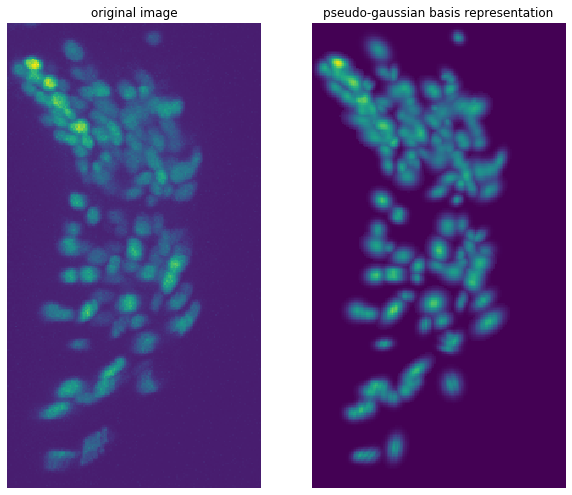

In [19]:
#fig, axs = plt.subplots((figsize=(10, 10))
fig, axs = plt.subplots(
    1, 2, 
    sharex=True, sharey=True, 
    figsize=(10, 10)
)

vmin = min(np.min(img), np.min(rep_img))
vmax = max(np.max(img), np.max(rep_img))

ax = axs[0]
ax.imshow(np.max(img, 2).T, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.set_title('original image')

ax = axs[1]
ax.imshow(np.max(rep_img, 2).T, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.set_title('pseudo-gaussian basis representation')

fig.savefig('gaussian_representation_3.png')

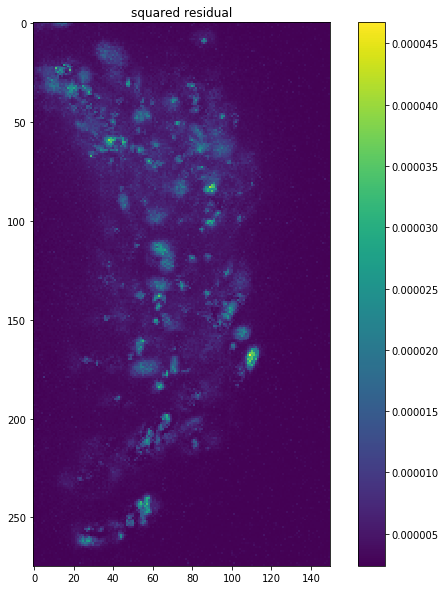

In [20]:
res = (rep_img - img) ** 2

plt.figure(figsize=(10, 10))
plt.imshow(np.max(res, 2).T)
plt.colorbar()
plt.title('squared residual')
plt.savefig('residual.png')